In [1]:
# Import Required Libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


In [25]:
# Preprocessing Function
def preprocess_binary_csv(csv_path, n_support, n_query):
    """
    Preprocess CSV data into support and query sets for binary classification.
    """
    df = pd.read_csv(csv_path)

    # Clean column names (remove extra spaces if any)
    df.columns = df.columns.str.strip()

    # Ensure all features are numeric and handle missing data
    feature_columns = df.columns.difference(['Label', 'Attack Type'])
    df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=feature_columns)

    # Separate the two classes: attack (1) and normal (0)
    attack_data = df[df["Label"] == 1]
    normal_data = df[df["Label"] == 0]

    print(f"Attack Samples: {len(attack_data)}")
    print(f"Normal Samples: {len(normal_data)}")

    # Ensure enough samples for support and query sets
    if len(attack_data) < n_support + n_query or len(normal_data) < n_support + n_query:
        raise ValueError("Not enough samples in one or more classes to split into support and query sets.")

    # Split each class into support and query sets
    attack_support, attack_query = train_test_split(attack_data, test_size=0.6, random_state=42)
    normal_support, normal_query = train_test_split(normal_data, test_size=0.6, random_state=42)

    # Select support and query samples
    attack_support = attack_support[:n_support]
    normal_support = normal_support[:n_support]
    attack_query = attack_query[:n_query]
    normal_query = normal_query[:n_query]

    # Combine the support and query sets
    support_set = pd.concat([attack_support, normal_support])
    query_set = pd.concat([attack_query, normal_query])

    # Convert to PyTorch tensors
    support_x = torch.tensor(support_set[feature_columns].values, dtype=torch.float32)
    support_y = torch.tensor(support_set["Label"].values, dtype=torch.int64)
    query_x = torch.tensor(query_set[feature_columns].values, dtype=torch.float32)
    query_y = torch.tensor(query_set["Label"].values, dtype=torch.int64)

    return support_x, support_y, query_x, query_y

In [29]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

def preprocess_and_oversample(csv_path, n_support, n_query):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    # Separate features and labels
    feature_columns = df.columns.difference(['Label'])
    X = df[feature_columns]
    y = df['Label']

    # Ensure all features are numeric
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Scale features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Oversample
    from imblearn.over_sampling import RandomOverSampler
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Split into support and query sets
    from sklearn.model_selection import train_test_split
    support_x, query_x, support_y, query_y = train_test_split(
        X_resampled, y_resampled, test_size=n_query / len(X_resampled), stratify=y_resampled, random_state=42
    )

    # Convert to PyTorch tensors (convert y explicitly to NumPy)
    return torch.tensor(support_x, dtype=torch.float32), \
           torch.tensor(support_y.to_numpy(), dtype=torch.int64), \
           torch.tensor(query_x, dtype=torch.float32), \
           torch.tensor(query_y.to_numpy(), dtype=torch.int64)



In [31]:
# Prototypical Network
class ProtoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim, dropout_rate=0.5):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # Batch normalization
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.fc2 = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # Batch norm and activation
        x = self.dropout(x)  # Dropout
        x = self.fc2(x)
        return x

    def set_forward_loss(self, support_x, support_y, query_x, query_y, lambda_reg=0.1):
        support_embed = self.forward(support_x)
        query_embed = self.forward(query_x)

        # Compute prototypes
        prototypes = self.compute_prototypes(support_embed, support_y)

        # Compute distances
        distances = self.compute_distances(query_embed, prototypes)

        # Weighted cross-entropy loss
        class_counts = torch.bincount(support_y)
        total_samples = len(support_y)
        class_weights = total_samples / (len(class_counts) * class_counts)
        class_weights = class_weights.to(distances.device)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fn(distances, query_y)

        # Prototype regularization (to ensure separation)
        proto_distances = torch.cdist(prototypes, prototypes)
        reg_loss = lambda_reg * (1 / (proto_distances + 1e-5)).sum()

        total_loss = loss + reg_loss
        accuracy = (distances.argmax(dim=1) == query_y).float().mean()
        return total_loss, accuracy




    def compute_prototypes(self, support_embed, support_y):
        unique_labels = torch.unique(support_y)
        prototypes = []
        for label in unique_labels:
            class_embed = support_embed[support_y == label]
            if class_embed.size(0) == 0:
                print(f"Warning: No samples for class {label}")
            prototypes.append(class_embed.mean(dim=0))
        prototypes = torch.stack(prototypes)
        #print(f"Prototypes: {prototypes}")
        return prototypes


    def compute_distances(self, query_embed, prototypes, metric='cosine'):
        if metric == 'cosine':
            # Normalize embeddings
            query_embed = nn.functional.normalize(query_embed, dim=1)
            prototypes = nn.functional.normalize(prototypes, dim=1)
            distances = 1 - torch.matmul(query_embed, prototypes.T)  # Cosine similarity
        else:
            # Default: Euclidean distance
            distances = torch.cdist(query_embed, prototypes)
        return distances


In [17]:
# Training Function with Early Stopping
def train_with_early_stopping(
    model, optimizer, support_x, support_y, query_x, query_y,
    n_way, n_support, n_query, max_epoch, epoch_size, patience=5
):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5, last_epoch=-1)
    prev_epoch_loss = float("inf")
    best_epoch = 0
    best_model_state = None
    epochs_no_improve = 0

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(max_epoch):
        # Training phase
        model.train()
        running_loss, running_acc = 0.0, 0.0
        for _ in tqdm(range(epoch_size), desc=f"Epoch {epoch + 1} train"):
            loss, acc = model.set_forward_loss(support_x, support_y, query_x, query_y)
            running_loss += loss.item()
            running_acc += acc.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = running_loss / epoch_size
        train_acc = running_acc / epoch_size
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        print(f"Epoch {epoch + 1} -- Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = model.set_forward_loss(support_x, support_y, query_x, query_y)
            val_loss = val_loss.item()
            val_acc = val_acc.item()

        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch + 1} -- Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Early stopping check
        if val_loss < prev_epoch_loss:
            prev_epoch_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step()

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Restored model from epoch {best_epoch + 1} with best validation loss: {prev_epoch_loss:.4f}")

    return history

In [18]:
# Visualization Function
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1 train: 100%|██████████| 200/200 [00:00<00:00, 277.15it/s]


Epoch 1 -- Train Loss: 20000.9036, Train Accuracy: 0.2534
Epoch 1 -- Validation Loss: 20000.9141, Validation Accuracy: 0.1800


Epoch 2 train: 100%|██████████| 200/200 [00:00<00:00, 275.11it/s]


Epoch 2 -- Train Loss: 20000.8996, Train Accuracy: 0.2617
Epoch 2 -- Validation Loss: 20000.9121, Validation Accuracy: 0.1800


Epoch 3 train: 100%|██████████| 200/200 [00:00<00:00, 283.94it/s]


Epoch 3 -- Train Loss: 20000.8963, Train Accuracy: 0.2666
Epoch 3 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 4 train: 100%|██████████| 200/200 [00:00<00:00, 275.71it/s]


Epoch 4 -- Train Loss: 20000.8974, Train Accuracy: 0.2597
Epoch 4 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 5 train: 100%|██████████| 200/200 [00:00<00:00, 275.07it/s]


Epoch 5 -- Train Loss: 20000.8967, Train Accuracy: 0.2639
Epoch 5 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 6 train: 100%|██████████| 200/200 [00:00<00:00, 277.28it/s]


Epoch 6 -- Train Loss: 20000.8961, Train Accuracy: 0.2631
Epoch 6 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 7 train: 100%|██████████| 200/200 [00:00<00:00, 282.86it/s]


Epoch 7 -- Train Loss: 20000.8969, Train Accuracy: 0.2602
Epoch 7 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 8 train: 100%|██████████| 200/200 [00:00<00:00, 273.65it/s]


Epoch 8 -- Train Loss: 20000.8961, Train Accuracy: 0.2612
Epoch 8 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 9 train: 100%|██████████| 200/200 [00:00<00:00, 272.45it/s]


Epoch 9 -- Train Loss: 20000.8959, Train Accuracy: 0.2602
Epoch 9 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 10 train: 100%|██████████| 200/200 [00:00<00:00, 282.57it/s]


Epoch 10 -- Train Loss: 20000.8958, Train Accuracy: 0.2671
Epoch 10 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 11 train: 100%|██████████| 200/200 [00:00<00:00, 281.51it/s]


Epoch 11 -- Train Loss: 20000.8959, Train Accuracy: 0.2616
Epoch 11 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 12 train: 100%|██████████| 200/200 [00:00<00:00, 234.60it/s]


Epoch 12 -- Train Loss: 20000.8956, Train Accuracy: 0.2590
Epoch 12 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800


Epoch 13 train: 100%|██████████| 200/200 [00:01<00:00, 195.71it/s]


Epoch 13 -- Train Loss: 20000.8958, Train Accuracy: 0.2628
Epoch 13 -- Validation Loss: 20000.9082, Validation Accuracy: 0.1800
Early stopping at epoch 13
Restored model from epoch 3 with best validation loss: 20000.9082


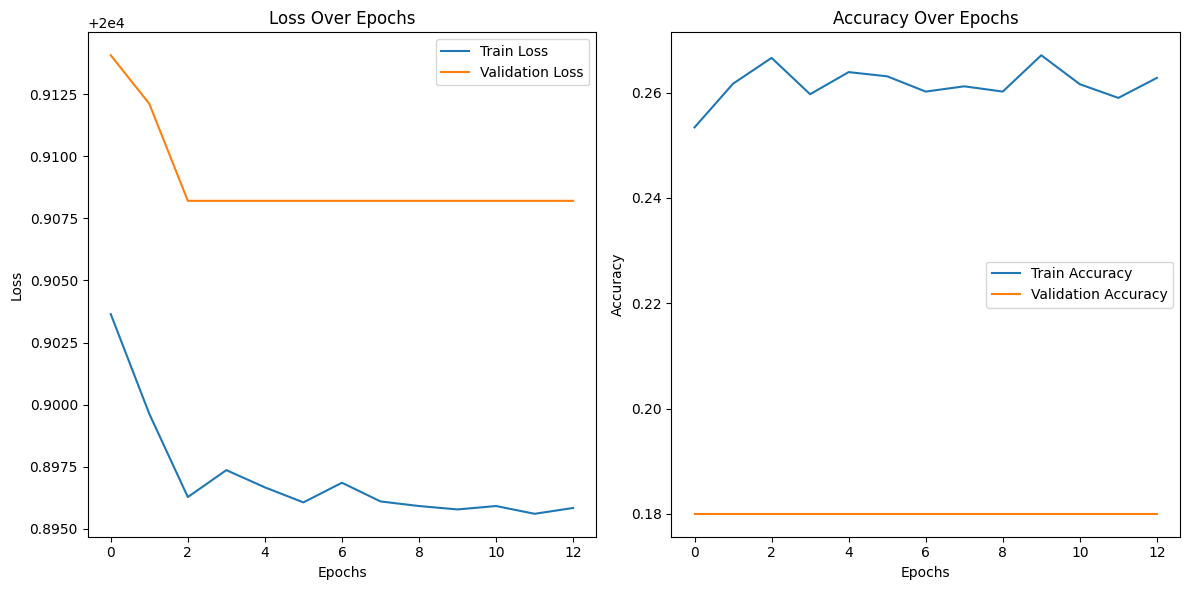

Test Accuracy: 82.00%
Precision: 0.8636, Recall: 0.7600, F1-Score: 0.8085


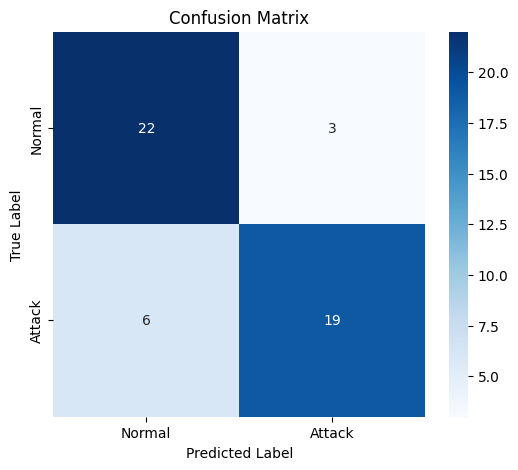

In [36]:
if __name__ == "__main__":
    csv_path = "Modified_dataset.csv"
    n_support = 30
    n_query = 50
    max_epoch = 50
    epoch_size = 200

    # Preprocess with oversampling
    support_x, support_y, query_x, query_y = preprocess_and_oversample(csv_path, n_support, n_query)

    # Initialize the model
    model = ProtoNet(
        input_dim=support_x.shape[1],
        hidden_dim=128,
        z_dim=64,
        dropout_rate=0.4
    ).to("cuda:0" if torch.cuda.is_available() else "cpu")

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.001)

    # Train
    history = train_with_early_stopping(
        model, optimizer, support_x, support_y, query_x, query_y,
        n_way=2, n_support=n_support, n_query=n_query,
        max_epoch=max_epoch, epoch_size=epoch_size, patience=10
    )

    # Save and evaluate
    torch.save(model.state_dict(), "protonet_final_model.pth")
    plot_training_history(history)

    model.eval()
    with torch.no_grad():
        query_embed = model(query_x)
        prototypes = model.compute_prototypes(model.forward(support_x), support_y)
        distances = model.compute_distances(query_embed, prototypes, metric='cosine')
        predictions = distances.argmin(dim=1)

        # Metrics
        test_accuracy = (predictions == query_y).float().mean().item()
        precision = precision_score(query_y.cpu(), predictions.cpu(), zero_division=1)
        recall = recall_score(query_y.cpu(), predictions.cpu(), zero_division=1)
        f1 = f1_score(query_y.cpu(), predictions.cpu(), zero_division=1)

    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(query_y.cpu(), predictions.cpu())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
